In [2]:
import os, pickle
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.svm import SVC
from aix360.algorithms.protodash import ProtodashExplainer
# from lime.lime_tabular import LimeTabularExplainer
# from lime.submodular_pick import SubmodularPick
import matplotlib.pyplot as plt
from pdash import pdash_e, proto_g
from protoclass.protoclass import ProtoclassExplainer, protoclass

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

In [3]:
METRIC = "auc"
WEIGHTS = "uniform"

def get_knn_score(k, data, index, metric=METRIC, weights=WEIGHTS):
    X_train, y_train, X_valid, y_valid = data
    knc = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = knc.predict_proba(X_valid)
        probs = probs[:, 1] if probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = knc.score(X_valid, y_valid)
    return score

def get_svm_score(k, data, index, metric=METRIC):
    X_train, y_train, X_valid, y_valid = data
    svc = SVC(probability=True, random_state=42)
    svc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = svc.predict_proba(X_valid)
        probs = probs[:, 1] if probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = svc.score(X_valid, y_valid)
    return score

def get_ci(samples, confidence=0.95):
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)

def get_nn(index, samples, m=1):
    dist = euclidean_distances(samples)
    neighbors = []
    for i in index:
        neighbors.append(np.argsort(dist[i])[1:m+1])
    return np.array(neighbors)



In [4]:

dataset_path = {
    'prostatex': '/net/scratch/hanliu/radiology/prostatex/tbakd3_npy/5folds/4/embs',
    # 'prostatex': '/net/scratch/hanliu-shared/tbakd3_npy/5folds/4/embs',
    'bm': '/net/scratch/hanliu/radiology/explain_teach/data/bm/embs',
}
dataset = 'prostatex'
model = 'dwac'
name = 'emb10.merged2'
train_path = '{}/{}_train_{}.pkl'.format(dataset_path[dataset], model, name)
valid_path = '{}/{}_valid_{}.pkl'.format(dataset_path[dataset], model, name)
f_train, _, y_train, X_train = pickle.load(open(train_path, "rb"))
f_valid, _, y_valid, X_valid = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid
pos_id = np.where(y_train > 0)[0]
neg_id = np.where(y_train == 0)[0]
L = 0.5
Kernel = 'Gaussian'
Gamma = 0.5

k_range = [1, 3]
m_range = list(range(3, 11))
f_scores = []
for k in k_range:
    score = get_svm_score(k, data, list(range(len(data[0]))))
    f_scores.append(score)
f_scores = np.array(f_scores)
f_scores

array([0.83236152, 0.83236152])

In [6]:
p_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in p_idss:
        try:
            protodash = ProtodashExplainer()
            _, index, _ = protodash.explain(X_train, X_train, m=m, kernelType="Gaussian")
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        p_idss[m] = index
# pickle.dump(p_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# p_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
p_scores_knn, p_scores_svm = [], []
for k in k_range:
    for m in m_range:
        p_scores_knn.append(get_knn_score(k, data, p_idss[m]))
        p_scores_svm.append(get_svm_score(k, data, p_idss[m]))
p_scores_knn = np.array(p_scores_knn).reshape(len(k_range), len(m_range))
p_scores_svm = np.array(p_scores_svm).reshape(len(k_range), len(m_range))

In [10]:
e_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in e_idss:
        try:
            mp, mn = (m+1)//2, m//2
            X_pos = X_train[y_train > 0]
            X_neg = X_train[y_train == 0]
            _, pos_index, _ = pdash_e(X_pos, X_pos, X_neg, m=mp, l=L, kernelType=Kernel)
            _, neg_index, _ = pdash_e(X_neg, X_neg, X_pos, m=mn, l=L, kernelType=Kernel)
            pos_index = pos_id[pos_index]
            neg_index = neg_id[neg_index]
            index = np.hstack((pos_index, neg_index))
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        e_idss[m] = index
# pickle.dump(e_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# e_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
e_scores_knn, e_scores_svm = [], []
for k in k_range:
    for m in m_range:
        e_scores_knn.append(get_knn_score(k, data, e_idss[m]))
        e_scores_svm.append(get_svm_score(k, data, e_idss[m]))
e_scores_knn = np.array(e_scores_knn).reshape(len(k_range), len(m_range))
e_scores_svm = np.array(e_scores_svm).reshape(len(k_range), len(m_range))

In [9]:
g_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in g_idss:
        try:
            mp, mn = (m+1)//2, m//2
            pos_index = proto_g(X_pos, np.arange(X_pos.shape[0]), m=mp)
            neg_index = proto_g(X_neg, np.arange(X_neg.shape[0]), m=mn)
            pos_index = pos_id[pos_index]
            neg_index = neg_id[neg_index]
            index = np.hstack((pos_index, neg_index))
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        g_idss[m] = index
# pickle.dump(g_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# g_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
g_scores_knn, g_scores_svm = [], []
for k in k_range:
    for m in m_range:
        g_scores_knn.append(get_knn_score(k, data, g_idss[m]))
        g_scores_svm.append(get_svm_score(k, data, g_idss[m]))
g_scores_knn = np.array(g_scores_knn).reshape(len(k_range), len(m_range))
g_scores_svm = np.array(g_scores_svm).reshape(len(k_range), len(m_range))

In [11]:
c_idss = {}
X_train, y_train, X_valid, y_valid = data
_, c_idss = protoclass(X_train, X_train, y_train, m_range)
# pickle.dump(c_idss, open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "wb"))
# c_idss = pickle.load(open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "rb"))
print([len(ids) for ids in c_idss.values()])
c_scores_knn, c_scores_svm = [], []
for k in k_range:
    for m in m_range:
        c_scores_knn.append(get_knn_score(k, data, c_idss[m]))
        c_scores_svm.append(get_svm_score(k, data, c_idss[m]))
c_scores_knn = np.array(c_scores_knn).reshape(len(k_range), len(m_range))
c_scores_svm = np.array(c_scores_svm).reshape(len(k_range), len(m_range))

[3, 4, 5, 6, 7, 8, 9, 10]


In [14]:
n_trials = 100
r_scores_knn, r_scores_svm = [], []
np.random.seed(42)
for k in k_range:
    for m in m_range:
        scores_knn, scores_svm = [], []
        i = 0
        while i < n_trials:
            index = np.random.choice(range(len(X_train)), m, replace=False)
            if len(np.unique(y_train[index])) < 2: continue
            scores_knn.append(get_knn_score(k, data, index))
            scores_svm.append(get_svm_score(k, data, index))
            i += 1
        r_scores_knn.append((scores_knn))
        r_scores_svm.append((scores_svm))
r_scores_knn = np.array(r_scores_knn).reshape(len(k_range), len(m_range), n_trials)
r_scores_svm = np.array(r_scores_svm).reshape(len(k_range), len(m_range), n_trials)
# pickle.dump(r_scores, open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "wb"))
# r_scores = pickle.load(open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "rb"))
r_means_knn = r_scores_knn.mean(axis=-1)
r_confs_knn = np.array([get_ci(r_scores_knn[k][m]) for m in range(len(m_range)) for k in range(len(k_range))])
r_means_svm = r_scores_svm.mean(axis=-1)
r_confs_svm = np.array([get_ci(r_scores_svm[k][m]) for m in range(len(m_range)) for k in range(len(k_range))])

Text(0.5, 0.98, 'prostatex, dwac.emb10.merged2, AUC, KNN weights uniform')

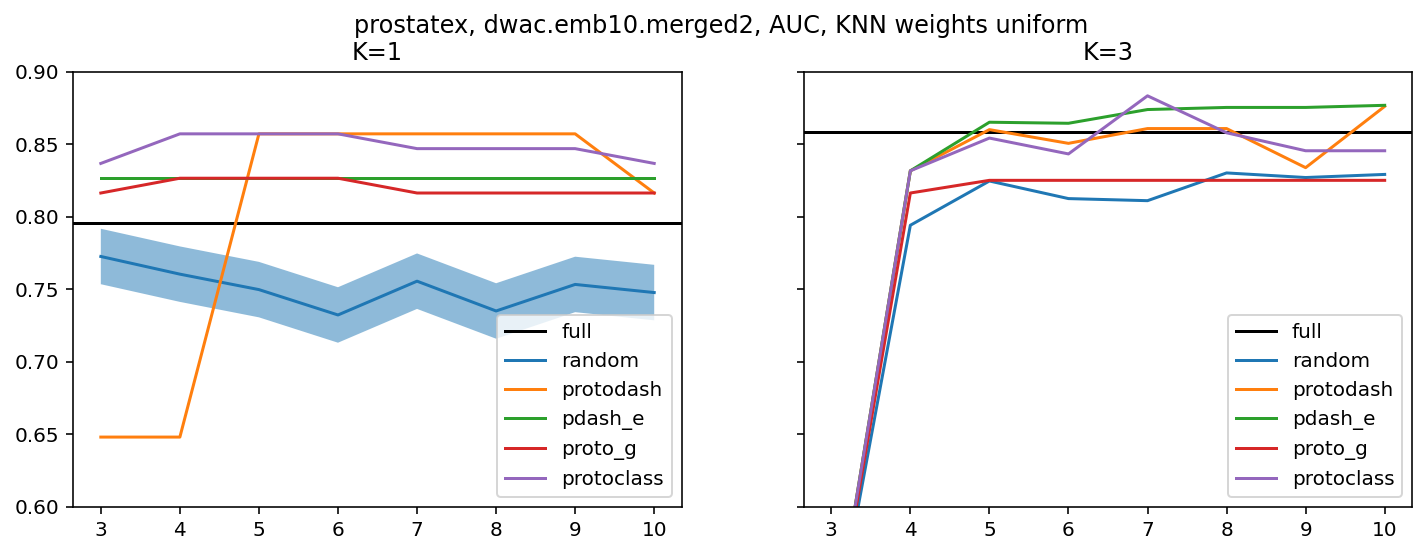

In [15]:
fig, ax = plt.subplots(1, len(k_range), figsize=(12, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_means_knn[k])
    ax[k].fill_between(m_range, r_means_knn[k] + r_confs_knn[k] / 2, r_means_knn[k] - r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores_knn[k])
    ax[k].plot(m_range, e_scores_knn[k])
    ax[k].plot(m_range, g_scores_knn[k])
    ax[k].plot(m_range, c_scores_knn[k])
    ax[k].set_ylim(0.6, 0.9)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', 'protodash', 'pdash_e', 'proto_g', 'protoclass'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, name) + WEIGHTS)

NameError: name 'r_means_svm' is not defined

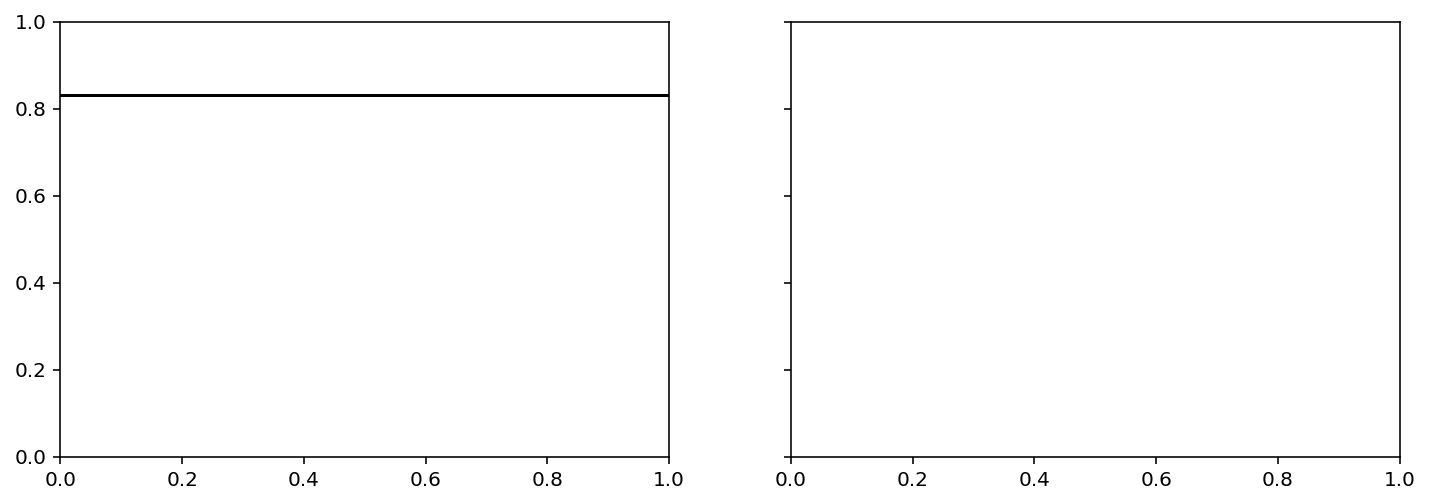

In [5]:
fig, ax = plt.subplots(1, len(k_range), figsize=(12, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores[k], c='black')
    ax[k].plot(m_range, r_means_svm[k])
    ax[k].fill_between(m_range, r_means_svm[k] + r_confs_svm[k] / 2, r_means_svm[k] - r_confs_svm[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores_svm[k])
    ax[k].plot(m_range, e_scores_svm[k])
    ax[k].plot(m_range, g_scores_svm[k])
    ax[k].plot(m_range, c_scores_svm[k])
    ax[k].set_ylim(0.6, 0.9)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', 'protodash', 'pdash_e', 'proto_g', 'protoclass'])
fig.suptitle('{}, {}.{}, AUC, svm'.format(dataset, model, name))

Text(0.5, 1.0, 'protoclass, dwac.emb10.merged2.t1')

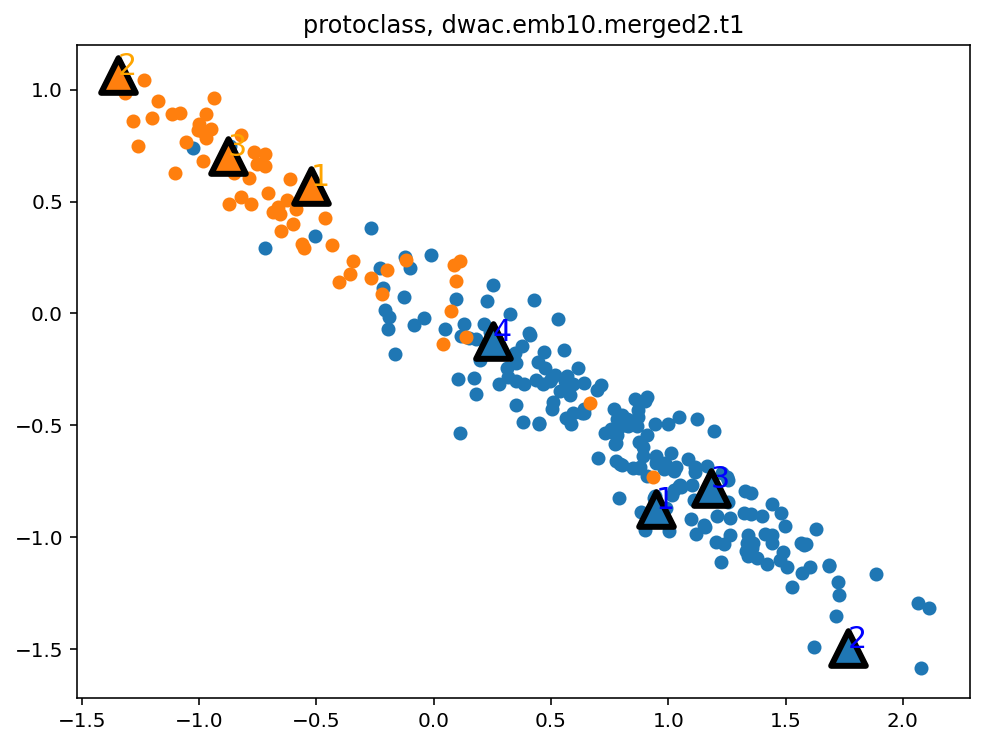

In [11]:
algo = 'protoclass'
index = c_idss[7]
p_index = [i for i in index if i in pos_id]
n_index = [i for i in index if i in neg_id]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name)

Text(0.5, 1.0, 'protoclass, dwac.emb10.merged2')

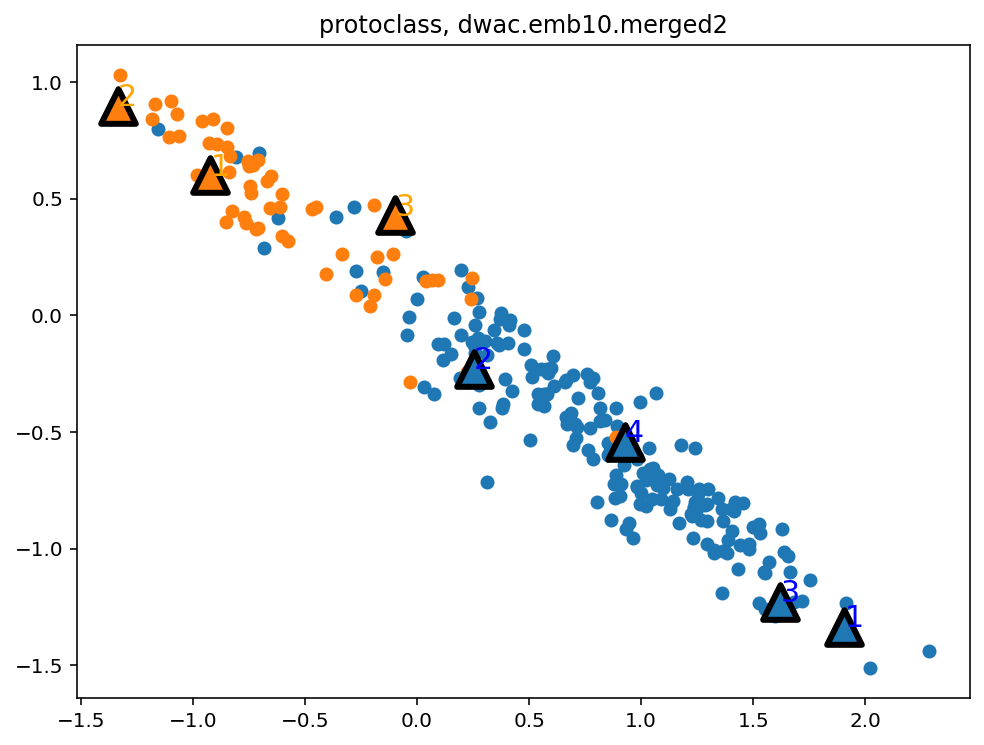

In [ ]:
algo = 'protoclass'
index = c_idss[7]
p_index = [i for i in index if i in pos_id]
n_index = [i for i in index if i in neg_id]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name)

In [12]:
dist = euclidean_distances(X_train)
p_nn = get_nn(p_index, X_train, m=1)
n_nn = get_nn(n_index, X_train, m=1)
p_nn.ravel(), n_nn.ravel()

(array([239, 229, 103]), array([ 90, 135, 133, 183]))

In [13]:
f_train[n_nn.ravel()]

array(['0103-2', '0144-3', '0142-2', '0182-1'], dtype='<U6')

Text(0.5, 1.0, 'pdash_e, dwac.emb10.merged2, L=1, K=Gaussian')

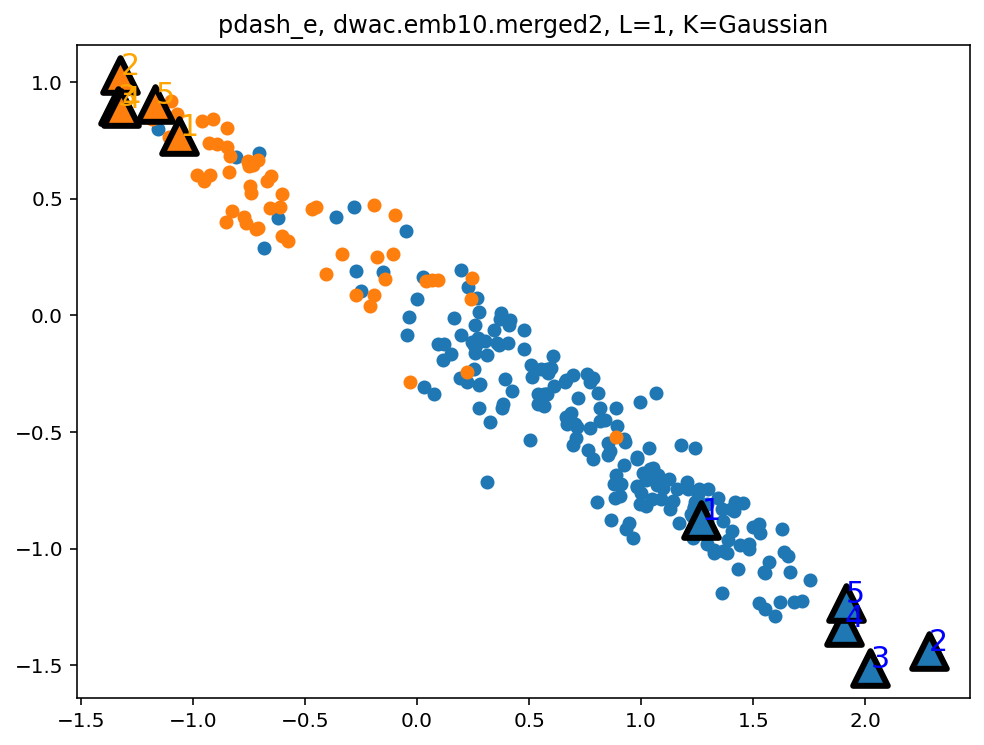

In [ ]:
algo = 'pdash_e'
p_index = e_idss[10][:5]
n_index = e_idss[10][5:]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name + ", L={}, K={}".format(L, Kernel))

AttributeError: 'numpy.ndarray' object has no attribute 'axhline'

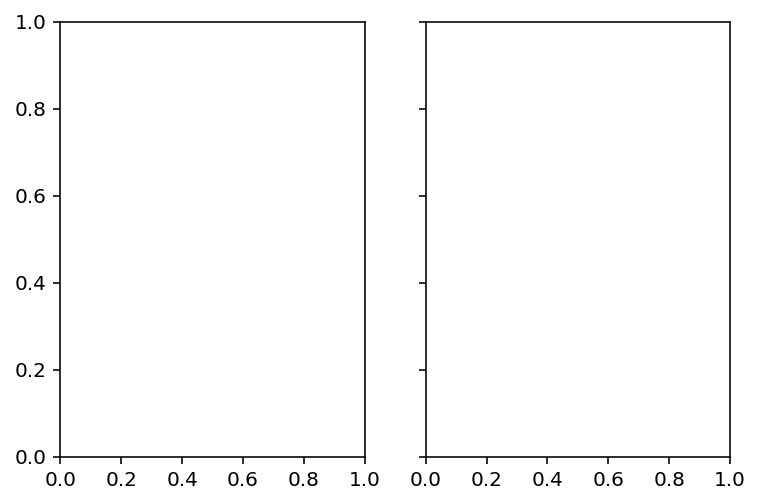

In [17]:
fig, ax = plt.subplots(1, len(k_range), figsize=(6, 4), sharey=True)
for k in range(len(k_range)):
    # ax[k].axhline(f_scores[k], c='black')
    # ax[k].plot(m_range, r_means[k])
    # ax[k].fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    # ax[k].plot(m_range, p_scores[k])
    # # ax[k].plot(m_range, s_scores[k])
    # # ax[k].set_ylim(0.9, 1.05)
    # ax[k].set_ylim(0.8, 1)
    # ax[k].legend(['full', 'random', 'protodash'], loc='lower right')
    # ax[k].set_title('K={}'.format(k_range[k]))
    ax.axhline(f_scores[k], c='black')
    ax.plot(m_range, r_means[k])
    ax.fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    ax.plot(m_range, p_scores[k])
    ax.plot(m_range, e_scores[k])
    ax.plot(m_range, g_scores[k])
    # ax.plot(m_range, s_scores[k])
    # ax.set_ylim(0.9, 1.05)
    ax.set_ylim(0, 1)
    ax.legend(['full', 'random', 'pdash', 'pdash_e', 'proto_g'])
    ax.set_title('K={}'.format(k_range[k]))
fig.suptitle('{}.{}, D={}, AUC, KNN weights '.format(model, name, D) + WEIGHTS)